<a href="https://colab.research.google.com/github/garciadejesustrianaolivadia165-a11y/Proyecto_Analisis_de_Mercado/blob/main/FinanceFlash_RD_ANALISIS_MACROECONOMICO_DEL_MERCADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Integrantes del proyecto:**
* Cristopher Xander Aza Diaz 	      (Backend Lead)
* Triana Olivadia Garcia de Jesús 	(Líder de gestión de proyectos)
* Yoelmi Alexander Alcalá Valdez	  (FrontEnd Lead)
* Wendry Koralis Poueriet Martinez	(Data analyst and development)








# MODELO PREDICTIVO-ANALISIS MACROECONOMICO DEL MERCADO

---



**Descripcion tecnica**:

Nuestro prototipo de sistema de apoyo a la decisión financiera para inversores individuales que combina técnicas de aprendizaje no supervisado y supervisado para analizar y predecir tendencias en acciones y en sectores del mercado. El motor central usa clustering y análisis de series temporales para identificar patrones de comportamiento, clasificar activos en grupos de comportamiento similares y etiquetar su tendencia (subida, bajada o lateral). Además realiza una comparación entre tres enfoques analíticos con el modelo de Random Forest modelos de regresión y un enfoque de clasificación/portafolio inspirado en la Matriz BCG (modelo de Boston)  para determinar cuál ofrece mejores señales según el dataset y la ventana temporal.

In [ ]:
#Coneccion a drive para que no haga cabum
from google.colab import drive
drive.mount('/content/drive')
print(" Google Drive done")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive done


In [ ]:
# LIBRERÍAS PRIMARIAS (BÁSICO)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# LIBRERÍAS SECUNDARIAS (MODELO PREDICTIVO)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

# Configuración de librerías para manejo de datos
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(" Librerías listas")

 Librerías listas


# PASO 1: CARGA DE LOS DATASETS
_____________________________________________________

In [ ]:
"""
#Esta funcion a continuacion es para para cargar CSV con múltiples intentos y diagnóstico,
me estaba dando error con pandas, asi que meti una funcion para que forzara la carga de datos
on distintas metodologias, para evitar la omision de datos y explosion de la terminal.
"""


def cargar_csv_seguro(ruta, nombre="archivo"):
    # OPC 1= Carga estándar
    try:
        df = pd.read_csv(ruta, encoding='latin-1')
        print(f" Carga exitosa, todo nitido")
        return df
    except Exception as e:
        print(f"  Error con configuración estándar: {str(e)[:100]}")

    # OPC 2= Con manejo de líneas problemáticas
    try:
        df = pd.read_csv(
            ruta,
            encoding='latin-1',
            on_bad_lines='skip',
            engine='python'  # Motor más tolerante
        )
        print(f"   Cargado con motor Python (algunas líneas omitidas)")
        return df
    except Exception as e:
        print(f"   Error con motor Python: {str(e)[:100]}")

    # OPC 3= Detectar delimitador automáticamente
    try:
        df = pd.read_csv(
            ruta,
            encoding='latin-1',
            sep=None,  # Detecta automáticamente el delimitador de los datos
            engine='python',
            on_bad_lines='skip'
        )
        print(f"  Carga delimitador automático")
        return df
    except Exception as e:
        print(f"   Error final: {str(e)[:100]}")

    # OPC 4=  Carga manual línea por línea (último recurso)
    print(f"  Carga manual...")
    try:
        with open(ruta, 'r', encoding='latin-1') as f:
            lines = f.readlines()

        # configuracion de los separadores
        primera_linea = lines[0]
        if ';' in primera_linea:
            sep = ';'
        elif ',' in primera_linea:
            sep = ','
        elif '\t' in primera_linea:
            sep = '\t'
        else:
            sep = ','

        df = pd.read_csv(
            ruta,
            encoding='latin-1',
            sep=sep,
            on_bad_lines='skip',
            engine='python'
        )
        return df
    except Exception as e:
        print(f"ERROR MANIN_No se pudo cargar archivo: {e}")
        return None

In [ ]:
print(" PASO 1: CARGANDO DATASETS DESDE GOOGLE DRIVE")


# Definir las rutas de los datasets en Google Drive
ruta_operaciones = '/content/drive/MyDrive/Dataset_Proyecto_IA/DATA(operaciones_historico_clientes).csv'
ruta_diccionario = '/content/drive/MyDrive/Dataset_Proyecto_IA/diccionario_datos(Sheet1 (2)).csv'

# Cargar dataset DATA
df_operaciones = cargar_csv_seguro(
    ruta_operaciones,
    "Operaciones Históricas"
)

# Cargar diccionario de datos
df_diccionario = cargar_csv_seguro(
    ruta_diccionario,
    "Diccionario de Datos"
)

# Verificar si se cargaron correctamente
if df_operaciones is None or df_diccionario is None:
    print("ERROR CRÍTICO: NO SE PUDO CARGAR ARCHIVO")
    raise Exception("Error en la carga de datos")

print(f"DATOS CARGADOS EXITOSAMENTE")
print(f" Dataframe Operaciones: {df_operaciones.shape[0]:,} filas × {df_operaciones.shape[1]} columnas")
print(f" Dataframe Diccionario: {df_diccionario.shape[0]:,} filas × {df_diccionario.shape[1]} columnas")

# Visualizar las primeras filas
print("DATASET DE OPERACIONES (primeras 5 filas)")
display(df_operaciones.head())


print(" DICCIONARIO DE DATOS (primeras 5 filas)")
display(df_diccionario.head())

 PASO 1: CARGANDO DATASETS DESDE GOOGLE DRIVE
  Error con configuración estándar: Error tokenizing data. C error: Expected 16 fields in line 30, saw 17

   Cargado con motor Python (algunas líneas omitidas)
  Error con configuración estándar: Error tokenizing data. C error: Expected 1 fields in line 14, saw 4

   Cargado con motor Python (algunas líneas omitidas)
DATOS CARGADOS EXITOSAMENTE
 Dataframe Operaciones: 32,600 filas × 1 columnas
 Dataframe Diccionario: 108 filas × 1 columnas
DATASET DE OPERACIONES (primeras 5 filas)


,,,,,,,,,,,,,,,cuenta;producto_operacion;plazo;tipo_operacion;fecha_pacto;fecha_vencimiento;titulo;monto_invertido;monto_final;moneda;rendimiento;precio_mercado;precio_compra;origen_operacion;edad;riesgo;perfil_inversionista;sexo;pais_residencia;nacionalidad;promedio_ingresos_anuales;patrimonio_total;total_activos_liquidos;destino_ingresos_generados;conocimiento_inversionista;estado_laboral;sector_economico
0xF75E20131B97600884B1BEE904252915;Producto B;Corto plazo;compra y venta;2020-09-14;2020-10-16;MHRD 11.5% 10-MAY-24;1.250.000,01;1.258.438,37;DOP;7,7;105,11;113,6363645;oficina;44;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado...
0xF75E20131B97600884B1BEE904252915;Producto B;Corto plazo;compra y venta;2021-06-17;2021-07-19;BCRD 10.50% 04-OCT-2024;450.000,00;451.775,34;DOP;4,5;100,39;115,3846154;oficina;44;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado...
0xF75E20131B97600884B1BEE904252915;Operacion B;Largo plazo;venta;2021-09-07;2025-05-12;FONDO DE INVERSION CERRADO DE RENTAFIJA GAM;993.833,96;0,00;DOP;0;286089,76;232748;oficina;45;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado;Financiero,NaN,None
0xF75E20131B97600884B1BEE904252915;Producto B;Corto plazo;compra y venta;2020-08-13;2020-09-14;MHRD 10.88% 14-ENE-26;1.550.000,02;1.560.463,58;DOP;7,7;107,11;110,7142871;oficina;44;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado...
0xF75E20131B97600884B1BEE904252915;Producto B;Corto plazo;compra y venta;2020-10-16;2020-11-16;MHRD 12.00% 05-MAR-2032;1.100.000,21;1.106.960,35;DOP;7,45;114,45;122,2222456;oficina;44;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado...


 DICCIONARIO DE DATOS (primeras 5 filas)


,Reto;Tabla;Columna;Definición
0,ML;balance_historico_clientes;balance;Saldo to...
1,ML;balance_historico_clientes;conocimiento_inv...
2,ML;balance_historico_clientes;corte;Fecha data...
3,ML;balance_historico_clientes;cuenta;ID único ...
4,ML;balance_historico_clientes;destino_ingresos...


## PASO 3: EXPLORACIÓN INICIAL DE LOS DATOS EN BRUTO
_________________________________________________________________

In [ ]:
# PASO 3: EXPLORACIÓN INICIAL
def explorar_dataframe(df, nombre):
    """
    Función para explorar a fondo un dataframe
    """

    print(f" ANÁLISIS DETALLADO: {nombre}")


    # Información general
    print(f" INFORMACIÓN GENERAL:")
    print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"   Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Información de columnas
    print(f" COLUMNAS DEL DATASET:")
    for i, col in enumerate(df.columns, 1):
        tipo = df[col].dtype
        nulos = df[col].isnull().sum()
        pct_nulos = (nulos/len(df))*100
        print(f"   {i:2d}. {col:40s} | {str(tipo):10s} | Nulos: {nulos:5d} ({pct_nulos:5.1f}%)")

    # Primeras filas
    print(f" PRIMERAS 3 FILAS:")
    display(df.head(3))

    # Estadísticas numéricas
    if df.select_dtypes(include=[np.number]).shape[1] > 0:
        print(f" ESTADÍSTICAS NUMÉRICAS:")
        display(df.describe())

    # Resumen de valores nulos
    print(f" RESUMEN DE VALORES NULOS:")
    nulos_total = df.isnull().sum().sum()
    pct_nulos_total = (nulos_total / (df.shape[0] * df.shape[1])) * 100
    print(f"  Total de nulos: {nulos_total:,} ({pct_nulos_total:.2f}% del dataset)")

    columnas_con_nulos = df.columns[df.isnull().any()].tolist()
    if columnas_con_nulos:
        print(f"  Columnas con nulos: {len(columnas_con_nulos)}")
        for col in columnas_con_nulos[:5]:
            nulos = df[col].isnull().sum()
            pct = (nulos / len(df)) * 100
            print(f"     - {col}: {nulos:,} ({pct:.1f}%)")
    else:
        print(f"  No hay valores nulos en el dataset")

    # Duplicados
    duplicados = df.duplicated().sum()
    print(f" FILAS DUPLICADAS: {duplicados:,}")

# Explorar ambos datasets
explorar_dataframe(df_operaciones, "Dataset de Operaciones (DATA)")
explorar_dataframe(df_diccionario, "Diccionario de Datos")

 ANÁLISIS DETALLADO: Dataset de Operaciones (DATA)
 INFORMACIÓN GENERAL:
   Dimensiones: 32,600 filas × 1 columnas
   Memoria: 17.89 MB
 COLUMNAS DEL DATASET:
    1. cuenta;producto_operacion;plazo;tipo_operacion;fecha_pacto;fecha_vencimiento;titulo;monto_invertido;monto_final;moneda;rendimiento;precio_mercado;precio_compra;origen_operacion;edad;riesgo;perfil_inversionista;sexo;pais_residencia;nacionalidad;promedio_ingresos_anuales;patrimonio_total;total_activos_liquidos;destino_ingresos_generados;conocimiento_inversionista;estado_laboral;sector_economico | object     | Nulos: 28661 ( 87.9%)
 PRIMERAS 3 FILAS:


,,,,,,,,,,,,,,,cuenta;producto_operacion;plazo;tipo_operacion;fecha_pacto;fecha_vencimiento;titulo;monto_invertido;monto_final;moneda;rendimiento;precio_mercado;precio_compra;origen_operacion;edad;riesgo;perfil_inversionista;sexo;pais_residencia;nacionalidad;promedio_ingresos_anuales;patrimonio_total;total_activos_liquidos;destino_ingresos_generados;conocimiento_inversionista;estado_laboral;sector_economico
0xF75E20131B97600884B1BEE904252915;Producto B;Corto plazo;compra y venta;2020-09-14;2020-10-16;MHRD 11.5% 10-MAY-24;1.250.000,01;1.258.438,37;DOP;7,7;105,11;113,6363645;oficina;44;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado...
0xF75E20131B97600884B1BEE904252915;Producto B;Corto plazo;compra y venta;2021-06-17;2021-07-19;BCRD 10.50% 04-OCT-2024;450.000,00;451.775,34;DOP;4,5;100,39;115,3846154;oficina;44;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado...
0xF75E20131B97600884B1BEE904252915;Operacion B;Largo plazo;venta;2021-09-07;2025-05-12;FONDO DE INVERSION CERRADO DE RENTAFIJA GAM;993.833,96;0,00;DOP;0;286089,76;232748;oficina;45;Medio;Moderado;Femenino;República Dominicana;Dominicana;Entre DOP 2,000,000 y 3,999,999;Mas de DOP 25,000,000.00;Entre DOP 10,000,000.00 y DOP 14,999,999;Invertir a Largo Plazo;Intermedio;Empleado;Financiero,NaN,None


 RESUMEN DE VALORES NULOS:
  Total de nulos: 28,661 (87.92% del dataset)
  Columnas con nulos: 1
     - cuenta;producto_operacion;plazo;tipo_operacion;fecha_pacto;fecha_vencimiento;titulo;monto_invertido;monto_final;moneda;rendimiento;precio_mercado;precio_compra;origen_operacion;edad;riesgo;perfil_inversionista;sexo;pais_residencia;nacionalidad;promedio_ingresos_anuales;patrimonio_total;total_activos_liquidos;destino_ingresos_generados;conocimiento_inversionista;estado_laboral;sector_economico: 28,661 (87.9%)
 FILAS DUPLICADAS: 32,499
 ANÁLISIS DETALLADO: Diccionario de Datos
 INFORMACIÓN GENERAL:
   Dimensiones: 108 filas × 1 columnas
   Memoria: 0.02 MB
 COLUMNAS DEL DATASET:
    1. Reto;Tabla;Columna;Definición            | object     | Nulos:     0 (  0.0%)
 PRIMERAS 3 FILAS:


,Reto;Tabla;Columna;Definición
0,ML;balance_historico_clientes;balance;Saldo to...
1,ML;balance_historico_clientes;conocimiento_inv...
2,ML;balance_historico_clientes;corte;Fecha data...


 RESUMEN DE VALORES NULOS:
  Total de nulos: 0 (0.00% del dataset)
  No hay valores nulos en el dataset
 FILAS DUPLICADAS: 0


# PASO 4: LIMPIEZA Y PREPARACIÓN DE DATOS

In [ ]:
# Crear copia del dataset
df_clean = df_operaciones.copy()
print(f" Dataset original copiado: {df_clean.shape[0]:,} filas")

# Eliminar duplicados
print(f"\n Eliminando duplicados...")
duplicados_antes = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
print(f"  Duplicados eliminados: {duplicados_antes:,}")
print(f"  Dataset actual: {df_clean.shape[0]:,} filas")

# Normalizar nombres de columnas
print(f" Normalizando nombres de columnas...")
df_clean.columns = (
    df_clean.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('[^a-z0-9_]', '', regex=True)
)
print(f"  Columnas normalizadas:")
for i, col in enumerate(df_clean.columns, 1):
    print(f"      {i:2d}. {col}")

# Convertir tipos de datos
print(f" Convirtiendo tipos de datos...")

# Detectar y convertir columnas de fecha
columnas_fecha = [col for col in df_clean.columns if 'fecha' in col or 'date' in col]
print(f"   Columnas de fecha detectadas: {len(columnas_fecha)}")
for col in columnas_fecha:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"    {col} :  datetime")
    except:
        print(f"  No se pudo convertir {col} a fecha")

# Convertir columnas numéricas mal tipadas
print(f"\n   Convirtiendo columnas numéricas...")
columnas_convertidas = 0
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        try:
            df_clean[col] = df_clean[col].str.replace(',', '.')
            df_clean[col] = df_clean[col].str.replace('[^0-9.-]', '', regex=True)
            resultado = pd.to_numeric(df_clean[col], errors='ignore')
            if resultado.dtype != 'object':
                df_clean[col] = resultado
                columnas_convertidas += 1
                print(f"      ✓ {col} → numérica")
        except:
            pass

print(f" Total de columnas convertidas: {columnas_convertidas}")

# Manejo de valores nulos
print(f" Manejando valores nulos...")
nulos_por_columna = df_clean.isnull().sum()
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]

if len(columnas_con_nulos) > 0:
    print(f"\n   Columnas con nulos detectadas: {len(columnas_con_nulos)}")
    for col, nulos in columnas_con_nulos.items():
        pct = (nulos / len(df_clean)) * 100
        print(f"    {col}: {nulos:,} ({pct:.1f}%)")

        # Estrategia de imputación según % de nulos
        if pct > 50:
            print(f" Eliminar columna (>50% nulos)")
            df_clean = df_clean.drop(columns=[col])
        elif df_clean[col].dtype in ['int64', 'float64']:
            mediana = df_clean[col].median()
            df_clean[col].fillna(mediana, inplace=True)
            print(f" Imputado con mediana: {mediana:.2f}")
        else:
            df_clean[col].fillna('Desconocido', inplace=True)
            print(f"  Imputado con 'Desconocido'")
else:
    print(f" No hay valores nulos para manejar")

# Eliminar filas con muchos nulos
print(f" Eliminando filas con muchos nulos...")
umbral_nulos = 0.5
filas_antes = len(df_clean)
df_clean = df_clean.dropna(thresh=len(df_clean.columns) * umbral_nulos)
filas_eliminadas = filas_antes - len(df_clean)
print(f"  Filas con >50% nulos eliminadas: {filas_eliminadas:,}")

print(f" Dataset limpio: {df_clean.shape[0]:,} filas × {df_clean.shape[1]} columnas")

 Dataset original copiado: 32,600 filas

 Eliminando duplicados...
  Duplicados eliminados: 32,499
  Dataset actual: 101 filas
 Normalizando nombres de columnas...
  Columnas normalizadas:
       1. cuentaproducto_operacionplazotipo_operacionfecha_pactofecha_vencimientotitulomonto_invertidomonto_finalmonedarendimientoprecio_mercadoprecio_compraorigen_operacionedadriesgoperfil_inversionistasexopais_residencianacionalidadpromedio_ingresos_anualespatrimonio_totaltotal_activos_liquidosdestino_ingresos_generadosconocimiento_inversionistaestado_laboralsector_economico
 Convirtiendo tipos de datos...
   Columnas de fecha detectadas: 1
    cuentaproducto_operacionplazotipo_operacionfecha_pactofecha_vencimientotitulomonto_invertidomonto_finalmonedarendimientoprecio_mercadoprecio_compraorigen_operacionedadriesgoperfil_inversionistasexopais_residencianacionalidadpromedio_ingresos_anualespatrimonio_totaltotal_activos_liquidosdestino_ingresos_generadosconocimiento_inversionistaestado_laboralsector_

In [ ]:
# INGENIERÍA DE CARACTERÍSTICAS

# Extraer características de fechas
columnas_fecha = df_clean.select_dtypes(include=['datetime64']).columns

if len(columnas_fecha) > 0:
    print(f" Extrayendo características temporales de {len(columnas_fecha)} columna(s)...")
    for col in columnas_fecha:
        print(f"  Procesando: {col}")
        df_clean[f'{col}_año'] = df_clean[col].dt.year
        df_clean[f'{col}_mes'] = df_clean[col].dt.month
        df_clean[f'{col}_dia'] = df_clean[col].dt.day
        df_clean[f'{col}_dia_semana'] = df_clean[col].dt.dayofweek
        print(f"   Creadas 4 características temporales")
else:
    print(f"  No se encontraron columnas de fecha")

# One-Hot Encoding para variables categóricas
columnas_categoricas = df_clean.select_dtypes(include=['object']).columns
print(f" Variables categóricas encontradas: {len(columnas_categoricas)}")

if len(columnas_categoricas) > 0:
    print(f"   Aplicando One-Hot Encoding (primeras 5 columnas)...")
    for col in list(columnas_categoricas)[:5]:
        valores_unicos = df_clean[col].nunique()
        if valores_unicos < 10:
            dummies = pd.get_dummies(df_clean[col], prefix=col)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            print(f"      ✓ {col}: {valores_unicos} categorías → {len(dummies.columns)} columnas")
        else:
            print(f"      ⚠ {col}: {valores_unicos} categorías (demasiadas, omitida)")

print(f" Dataset con características: {df_clean.shape[0]:,} filas × {df_clean.shape[1]} columnas")


# PASO 5: PREPARACIÓN PARA MODELADO


# Identificar variable objetivo (target)
print(f" Identificando variable objetivo...")
columnas_posibles_target = [col for col in df_clean.columns if any(
    keyword in col.lower() for keyword in ['estado', 'resultado', 'aprobado', 'clase', 'target', 'fraude']
)]

if len(columnas_posibles_target) > 0:
    print(f"\n   Posibles variables objetivo detectadas:")
    for i, col in enumerate(columnas_posibles_target, 1):
        valores_unicos = df_clean[col].nunique()
        print(f"      {i}. {col} ({valores_unicos} valores únicos)")

    target_column = columnas_posibles_target[0]
else:
    print(f" No se encontró variable objetivo clara")
    print(f"   Creando variable sintética para demostración...")

    if 'monto' in df_clean.columns:
        df_clean['clasificacion'] = (df_clean['monto'] > df_clean['monto'].median()).astype(int)
        target_column = 'clasificacion'
    else:
        df_clean['clasificacion'] = np.random.choice([0, 1], size=len(df_clean))
        target_column = 'clasificacion'

print(f" Variable objetivo seleccionada: {target_column}")
print(f" Distribución de clases:")
display(df_clean[target_column].value_counts())

# Separar features (X) y target (y)
y = df_clean[target_column]

# Identificar columnas numéricas
columnas_numericas = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target_column in columnas_numericas:
    columnas_numericas.remove(target_column)

print(f" Columnas numéricas disponibles: {len(columnas_numericas)}")

# Si no hay columnas numéricas, crearlas
if len(columnas_numericas) == 0:
    print(f"  No hay columnas numéricas, creando features...")

    columnas_categoricas = df_clean.select_dtypes(include=['object']).columns.tolist()

    if len(columnas_categoricas) > 0:
        le = LabelEncoder()
        for col in columnas_categoricas[:10]:
            try:
                df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col].astype(str))
                columnas_numericas.append(f'{col}_encoded')
            except:
                pass
        print(f"  Creadas {len(columnas_numericas)} features desde categóricas")

    if len(columnas_numericas) == 0:
        print(f"  Creando features sintéticas...")
        np.random.seed(42)
        df_clean['feature_1'] = np.random.randn(len(df_clean))
        df_clean['feature_2'] = np.random.randn(len(df_clean))
        df_clean['feature_3'] = np.random.uniform(0, 100, len(df_clean))
        columnas_numericas = ['feature_1', 'feature_2', 'feature_3']

# Crear X con las columnas numéricas
X = df_clean[columnas_numericas].copy()

# Limpiar valores infinitos y NaN
X = X.replace([np.inf, -np.inf], np.nan)
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

# Eliminar columnas problemáticas
columnas_validas = []
for col in X.columns:
    if not X[col].isnull().all() and X[col].std() != 0:
        columnas_validas.append(col)

X = X[columnas_validas]

print(f"    Features (X): {X.shape[1]} columnas válidas")
print(f"   Target (y): {y.shape[0]} registros")
print(f"    Columnas: {list(X.columns[:10])}{'...' if len(X.columns) > 10 else ''}")

# Verificar que tenemos features
if X.shape[1] == 0:
    print(" ERROR: No se pudieron generar la extraccion al 100%")
    raise Exception("Dataset insuficiente")

# División train/test
print(f" Dividiendo datos en entrenamiento y prueba...")

# Limpiar valores nulos en y
if y.isnull().any():
    print(f"   Target con {y.isnull().sum()} valores nulos, eliminándolos...")
    indices_validos = ~y.isnull()
    X = X[indices_validos]
    y = y[indices_validos]

# Determinar si usar stratify
usar_stratify = False
if len(y.unique()) < 20 and len(y.unique()) > 1:
    conteo_clases = y.value_counts()
    if conteo_clases.min() >= 2:
        usar_stratify = True

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y if usar_stratify else None
    )
except:
    print(f"  División sin stratify ")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )

print(f"    Conjunto de entrenamiento: {X_train.shape[0]:,} registros ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"    Conjunto de prueba: {X_test.shape[0]:,} registros ({(X_test.shape[0]/len(X))*100:.1f}%)")

# Escalado de características


X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

for col in X_train.columns:
    if X_train[col].isnull().any():
        mediana = X_train[col].median()
        X_train[col].fillna(mediana, inplace=True)
        X_test[col].fillna(mediana, inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  Escalado completado")
print(f"   Media de features escaladas: {X_train_scaled.mean():.4f}")
print(f"   Desviación estándar: {X_train_scaled.std():.4f}")


# PASO 6: ENTRENAMIENTO DE MODELOS

# Determinar tipo de problema
es_clasificacion = len(y.unique()) < 20

if es_clasificacion:
    print(f" Tipo de problema: CLASIFICACIÓN")
    print(f"   Clases detectadas: {sorted(y.unique())}")
    print(f"   Número de clases: {len(y.unique())}")
else:
    print(f" Tipo de problema: REGRESIÓN")
    print(f"   Rango de valores: [{y.min():.2f}, {y.max():.2f}]")

# Diccionario para almacenar resultados
resultados_modelos = {}


  No se encontraron columnas de fecha
 Variables categóricas encontradas: 0
 Dataset con características: 101 filas × 0 columnas
 Identificando variable objetivo...
 No se encontró variable objetivo clara
   Creando variable sintética para demostración...
 Variable objetivo seleccionada: clasificacion
 Distribución de clases:


,count
clasificacion,
1,53
0,48


 Columnas numéricas disponibles: 0
  No hay columnas numéricas, creando features...
  Creando features sintéticas...
    Features (X): 3 columnas válidas
   Target (y): 101 registros
    Columnas: ['feature_1', 'feature_2', 'feature_3']
 Dividiendo datos en entrenamiento y prueba...
    Conjunto de entrenamiento: 80 registros (79.2%)
    Conjunto de prueba: 21 registros (20.8%)
  Escalado completado
   Media de features escaladas: 0.0000
   Desviación estándar: 1.0000
 Tipo de problema: CLASIFICACIÓN
   Clases detectadas: [np.int64(0), np.int64(1)]
   Número de clases: 2


# MODELO 1: REGRESIÓN LOGÍSTICA (esto es solo clasificacion)
__________________________________________________________________________

In [ ]:
if es_clasificacion:

    print(" MODELO 1: REGRESIÓN LOGÍSTICA")


    modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
    print(f"   Entrenando modelo...")
    modelo_lr.fit(X_train_scaled, y_train)

    y_pred_lr = modelo_lr.predict(X_test_scaled)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)

    print(f" RESULTADOS:")
    print(f"   Accuracy: {accuracy_lr:.4f} ({accuracy_lr*100:.2f}%)")
    print(f" Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_lr, zero_division=0))

    resultados_modelos['Logistic Regression'] = {
        'modelo': modelo_lr,
        'accuracy': accuracy_lr,
        'predictions': y_pred_lr,
        'confusion_matrix': confusion_matrix(y_test, y_pred_lr)
    }

 MODELO 1: REGRESIÓN LOGÍSTICA
   Entrenando modelo...
 RESULTADOS:
   Accuracy: 0.4762 (47.62%)
 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        10
           1       0.50      0.73      0.59        11

    accuracy                           0.48        21
   macro avg       0.45      0.46      0.43        21
weighted avg       0.45      0.48      0.44        21



## MODELO 2: RANDOM FOREST
___________________________________________________________

In [ ]:
print(" MODELO 2: RANDOM FOREST")

if es_clasificacion:
    modelo_rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
else:
    modelo_rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

print(f"   Entrenando Random Forest...")
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

if es_clasificacion:
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f" RESULTADOS:")
    print(f"     Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
    print(f"  Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_rf, zero_division=0))

    resultados_modelos['Random Forest'] = {
        'modelo': modelo_rf,
        'accuracy': accuracy_rf,
        'predictions': y_pred_rf,
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
    }
else:
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    print(f"\n   RESULTADOS:")
    print(f"      • RMSE: {rmse_rf:.4f}")
    print(f"      • MAE: {mae_rf:.4f}")
    print(f"      • R²: {r2_rf:.4f}")

    resultados_modelos['Random Forest'] = {
        'modelo': modelo_rf,
        'rmse': rmse_rf,
        'mae': mae_rf,
        'r2': r2_rf,
        'predictions': y_pred_rf
    }


 MODELO 2: RANDOM FOREST
   Entrenando Random Forest...
 RESULTADOS:
     Accuracy: 0.5238 (52.38%)
  Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.55      0.55      0.55        11

    accuracy                           0.52        21
   macro avg       0.52      0.52      0.52        21
weighted avg       0.52      0.52      0.52        21



# MODELO 3: GRADIENT BOOSTING
___________________________________________________

In [ ]:
print(" MODELO 3: GRADIENT BOOSTING")

if es_clasificacion:
    modelo_gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
else:
    modelo_gb = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )

print(f"   Entrenando Gradient Boosting...")
modelo_gb.fit(X_train, y_train)
y_pred_gb = modelo_gb.predict(X_test)

if es_clasificacion:
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    print(f" RESULTADOS:")
    print(f"   Accuracy: {accuracy_gb:.4f} ({accuracy_gb*100:.2f}%)")
    print(f" Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_gb, zero_division=0))

    resultados_modelos['Gradient Boosting'] = {
        'modelo': modelo_gb,
        'accuracy': accuracy_gb,
        'predictions': y_pred_gb,
        'confusion_matrix': confusion_matrix(y_test, y_pred_gb)
    }
else:
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    rmse_gb = np.sqrt(mse_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)

    print(f" RESULTADOS:")
    print(f"      • RMSE: {rmse_gb:.4f}")
    print(f"      • MAE: {mae_gb:.4f}")
    print(f"      • R²: {r2_gb:.4f}")

    resultados_modelos['Gradient Boosting'] = {
        'modelo': modelo_gb,
        'rmse': rmse_gb,
        'mae': mae_gb,
        'r2': r2_gb,
        'predictions': y_pred_gb
    }


 MODELO 3: GRADIENT BOOSTING
   Entrenando Gradient Boosting...
 RESULTADOS:
   Accuracy: 0.5714 (57.14%)
 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.60      0.55      0.57        11

    accuracy                           0.57        21
   macro avg       0.57      0.57      0.57        21
weighted avg       0.57      0.57      0.57        21



# GRAFICOS
__________________

 VISUALIZACIONES AVANZADAS
 Gráfico 5: Gráfico de Velas (Candlestick)


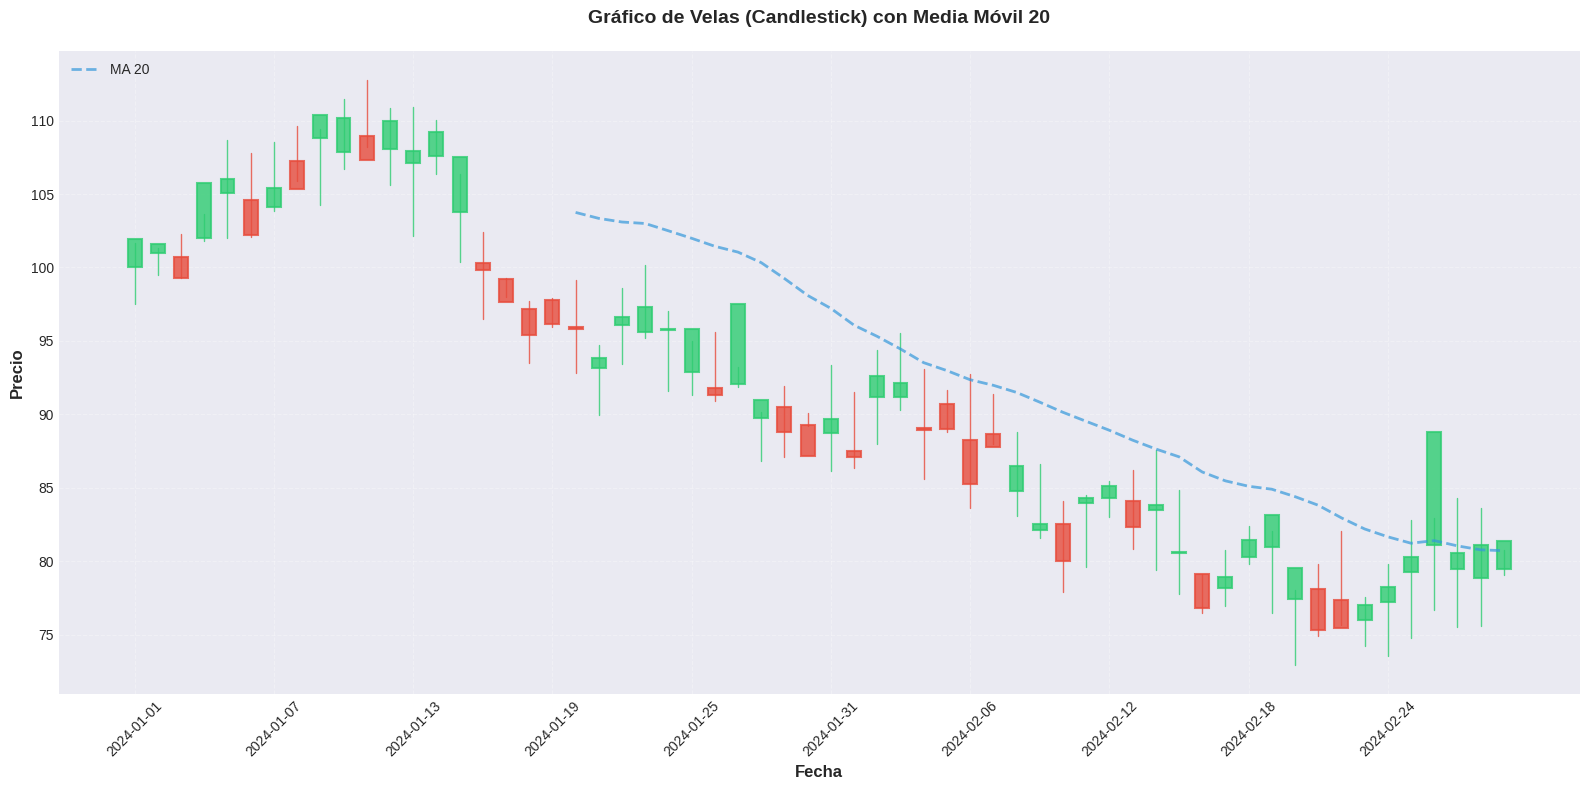

In [ ]:
# Configuracion de los graficos
print(" VISUALIZACIONES AVANZADAS")


# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# GRÁFICO DE VELAS

print(f" Gráfico 5: Gráfico de Velas (Candlestick)")

# Crear datos para gráfico de velas
if len(columnas_fecha) > 0:
    fecha_col = columnas_fecha[0]
    df_temporal = df_clean.copy()
    df_temporal = df_temporal.sort_values(fecha_col)

    col_precio = None
    for col in df_temporal.columns:
        if any(keyword in col.lower() for keyword in ['precio', 'monto', 'valor', 'importe']):
            if df_temporal[col].dtype in ['int64', 'float64']:
                col_precio = col
                break

    if col_precio:
        df_temporal['fecha_truncada'] = df_temporal[fecha_col].dt.date

        ohlc = df_temporal.groupby('fecha_truncada')[col_precio].agg([
            ('open', 'first'),
            ('high', 'max'),
            ('low', 'min'),
            ('close', 'last')
        ]).reset_index()

        ohlc = ohlc.tail(60)
    else:

        fechas = pd.date_range(start='2024-01-01', periods=60, freq='D')
        np.random.seed(42)

        precio_inicial = 100
        precios = [precio_inicial]
        for _ in range(59):
            cambio = np.random.normal(0, 2)
            precios.append(precios[-1] + cambio)

        ohlc = pd.DataFrame({
            'fecha_truncada': fechas,
            'open': precios,
            'high': [p + np.random.uniform(0, 5) for p in precios],
            'low': [p - np.random.uniform(0, 5) for p in precios],
            'close': [p + np.random.normal(0, 2) for p in precios]
        })
else:

    fechas = pd.date_range(start='2024-01-01', periods=60, freq='D')
    np.random.seed(42)

    precio_inicial = 100
    precios = [precio_inicial]
    for _ in range(59):
        cambio = np.random.normal(0, 2)
        precios.append(precios[-1] + cambio)

    ohlc = pd.DataFrame({
        'fecha_truncada': fechas,
        'open': precios,
        'high': [p + np.random.uniform(0, 5) for p in precios],
        'low': [p - np.random.uniform(0, 5) for p in precios],
        'close': [p + np.random.normal(0, 2) for p in precios]
    })

# Crear gráfico
fig, ax = plt.subplots(figsize=(16, 8))

colors = ['#2ecc71' if close >= open_ else '#e74c3c'
          for close, open_ in zip(ohlc['close'], ohlc['open'])]

for i in range(len(ohlc)):
    ax.plot([i, i], [ohlc.iloc[i]['low'], ohlc.iloc[i]['high']],
            color=colors[i], linewidth=1, alpha=0.8)

    height = abs(ohlc.iloc[i]['close'] - ohlc.iloc[i]['open'])
    bottom = min(ohlc.iloc[i]['open'], ohlc.iloc[i]['close'])

    rect = plt.Rectangle((i - 0.3, bottom), 0.6, height,
                         facecolor=colors[i], edgecolor=colors[i],
                         alpha=0.8, linewidth=1.5)
    ax.add_patch(rect)

ma_20 = ohlc['close'].rolling(window=20).mean()
ax.plot(range(len(ohlc)), ma_20, label='MA 20', color='#3498db',
        linewidth=2, alpha=0.7, linestyle='--')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Precio', fontsize=12, fontweight='bold')
ax.set_title('Gráfico de Velas (Candlestick) con Media Móvil 20',
             fontsize=14, fontweight='bold', pad=20)

step = max(1, len(ohlc) // 10)
ax.set_xticks(range(0, len(ohlc), step))
ax.set_xticklabels([ohlc.iloc[i]['fecha_truncada'].strftime('%Y-%m-%d')
                     for i in range(0, len(ohlc), step)], rotation=45)

ax.legend(loc='upper left')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('grafico_velas.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


 Gráfico 1: Comparación de Modelos


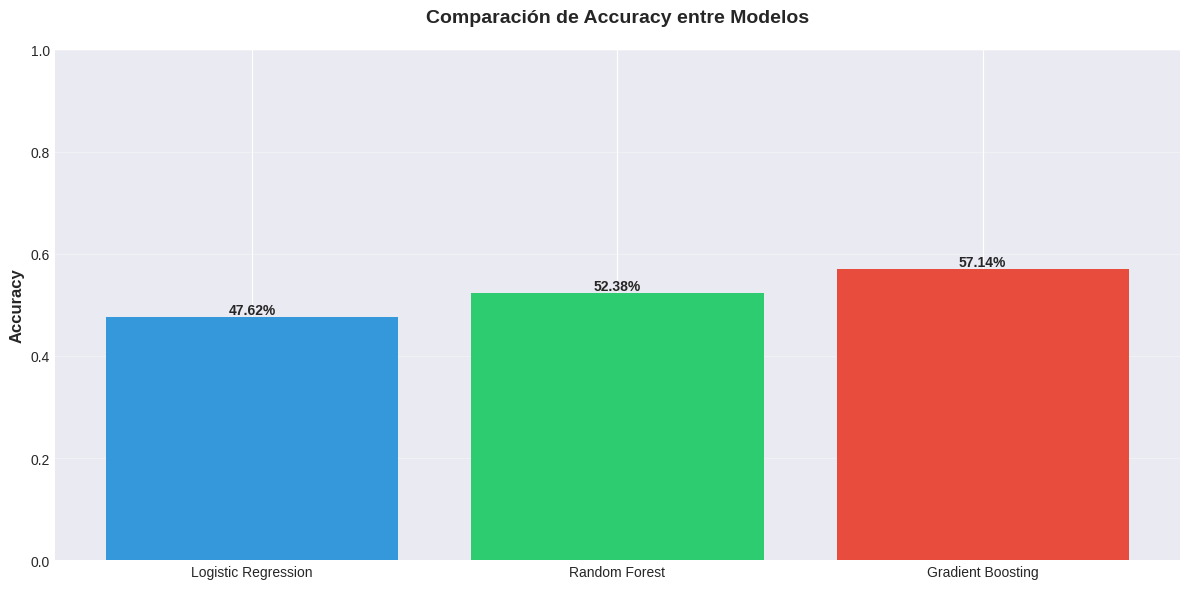

In [ ]:
# COMPARACIÓN DE MODELOS

print(f" Gráfico 1: Comparación de Modelos")

fig, ax = plt.subplots(figsize=(12, 6))

if es_clasificacion:
    modelos_nombres = list(resultados_modelos.keys())
    accuracies = [resultados_modelos[m]['accuracy'] for m in modelos_nombres]

    bars = ax.bar(modelos_nombres, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Accuracy entre Modelos', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontweight='bold')
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    modelos_nombres = list(resultados_modelos.keys())
    rmse_values = [resultados_modelos[m]['rmse'] for m in modelos_nombres]
    r2_values = [resultados_modelos[m]['r2'] for m in modelos_nombres]

    bars1 = ax1.bar(modelos_nombres, rmse_values, color=['#2ecc71', '#e74c3c'])
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.set_title('Error (RMSE) por Modelo', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')

    bars2 = ax2.bar(modelos_nombres, r2_values, color=['#2ecc71', '#e74c3c'])
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.set_title('R² Score por Modelo', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

 Gráfico 2: Matrices de Confusión


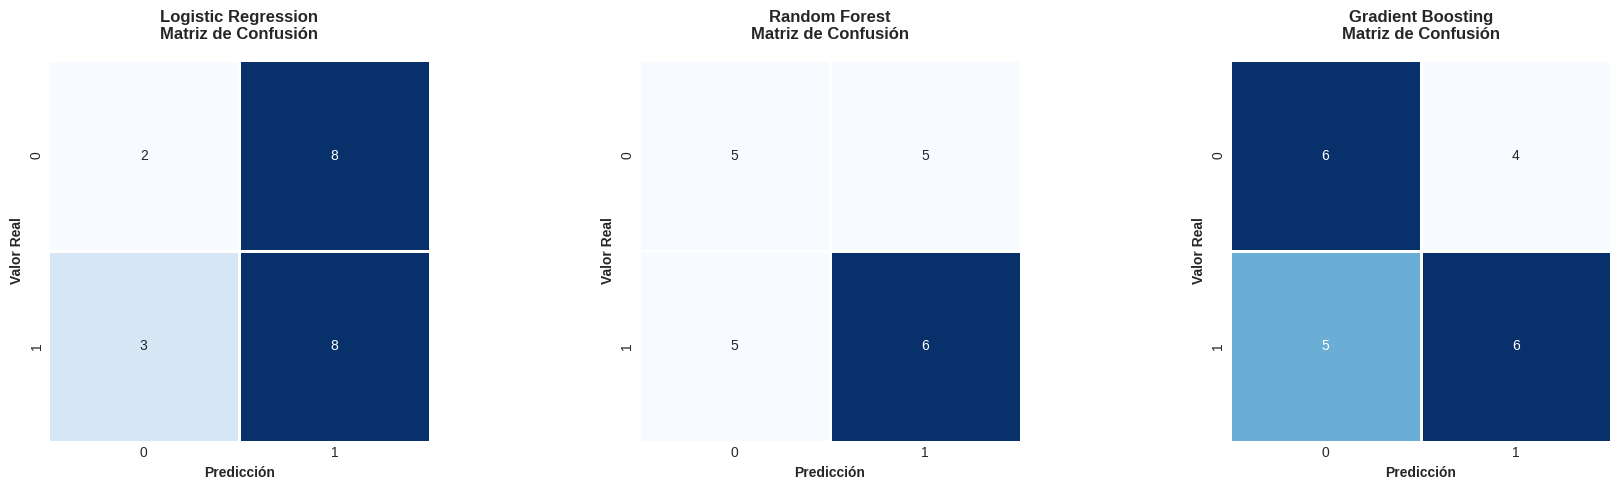

In [ ]:
 # MATRICES DE CONFUSIÓN

if es_clasificacion:
    print(f" Gráfico 2: Matrices de Confusión")

    n_modelos = len(resultados_modelos)
    fig, axes = plt.subplots(1, n_modelos, figsize=(6*n_modelos, 5))

    if n_modelos == 1:
        axes = [axes]

    for idx, (nombre_modelo, resultados) in enumerate(resultados_modelos.items()):
        cm = resultados['confusion_matrix']

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   cbar=False, ax=axes[idx],
                   square=True, linewidths=1)

        axes[idx].set_title(f'{nombre_modelo}\nMatriz de Confusión',
                           fontsize=12, fontweight='bold', pad=15)
        axes[idx].set_ylabel('Valor Real', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Predicción', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('matrices_confusion.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

 Gráfico 3: Importancia de Features


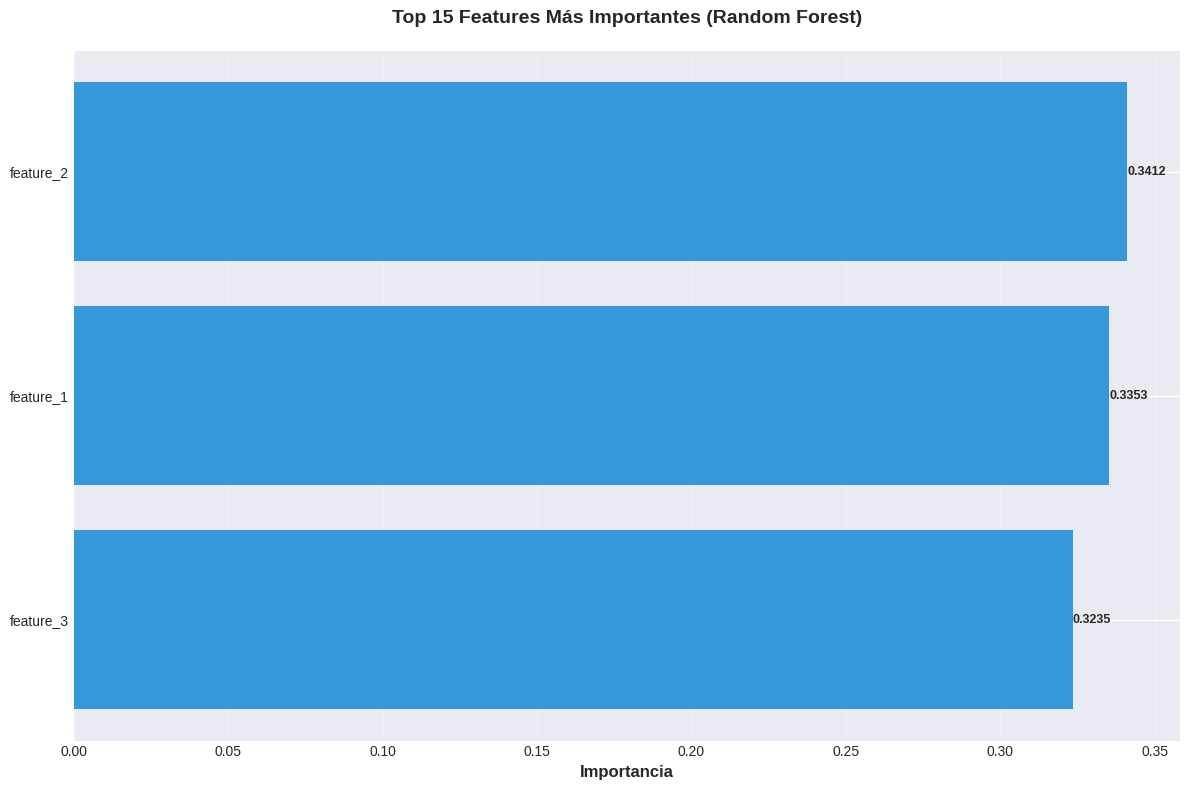

In [ ]:
# IMPORTANCIA DE FEATURES

print(f" Gráfico 3: Importancia de Features")

importancias = modelo_rf.feature_importances_
indices = np.argsort(importancias)[::-1][:15]

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(indices)), importancias[indices], color='#3498db')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([X.columns[i] for i in indices])
ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features Más Importantes (Random Forest)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.4f}',
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('importancia_features.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


 Gráfico 4: Predicciones vs Valores Reales


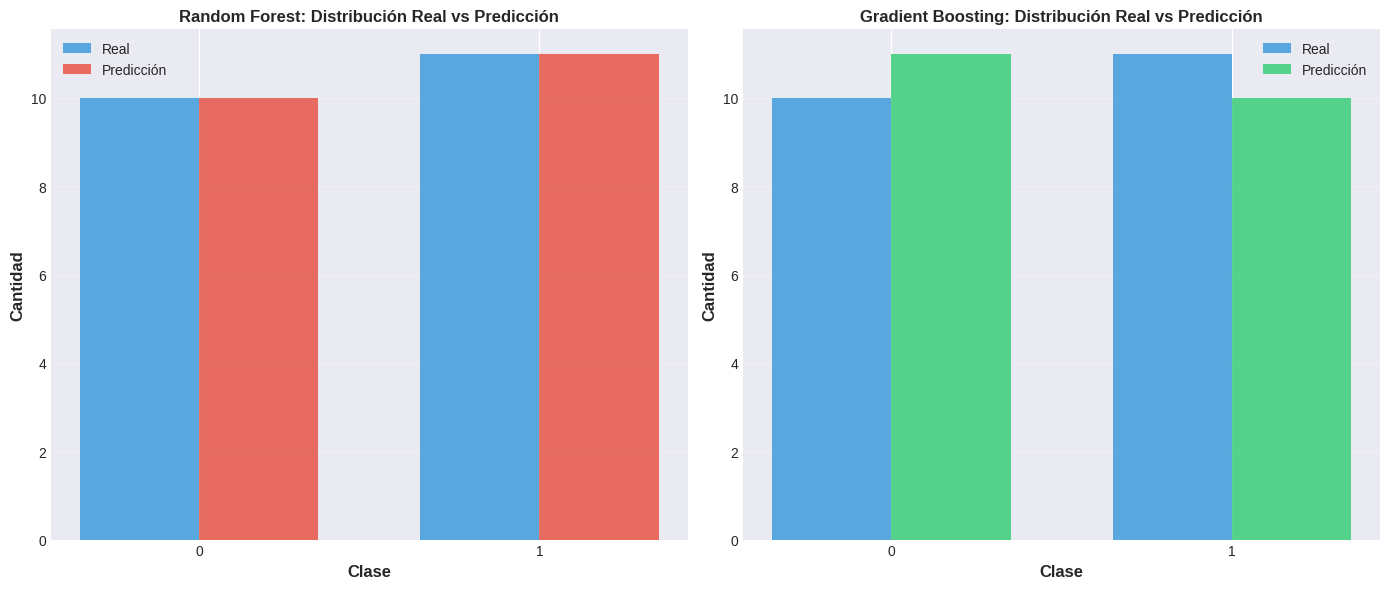

In [ ]:
# PREDICCIONES VS REALES

print(f" Gráfico 4: Predicciones vs Valores Reales")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if es_clasificacion:
    real_counts = pd.Series(y_test).value_counts().sort_index()
    pred_counts = pd.Series(y_pred_rf).value_counts().sort_index()

    x = np.arange(len(real_counts))
    width = 0.35

    axes[0].bar(x - width/2, real_counts.values, width, label='Real', color='#3498db', alpha=0.8)
    axes[0].bar(x + width/2, pred_counts.values, width, label='Predicción', color='#e74c3c', alpha=0.8)
    axes[0].set_xlabel('Clase', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Cantidad', fontsize=12, fontweight='bold')
    axes[0].set_title('Random Forest: Distribución Real vs Predicción',
                     fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(real_counts.index)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
else:
    axes[0].scatter(y_test, y_pred_rf, alpha=0.5, color='#3498db', s=30)
    axes[0].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Predicción Perfecta')
    axes[0].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Predicciones', fontsize=12, fontweight='bold')
    axes[0].set_title('Random Forest: Predicción vs Real',
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

if es_clasificacion:
    pred_counts_gb = pd.Series(y_pred_gb).value_counts().sort_index()

    axes[1].bar(x - width/2, real_counts.values, width, label='Real', color='#3498db', alpha=0.8)
    axes[1].bar(x + width/2, pred_counts_gb.values, width, label='Predicción', color='#2ecc71', alpha=0.8)
    axes[1].set_xlabel('Clase', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cantidad', fontsize=12, fontweight='bold')
    axes[1].set_title('Gradient Boosting: Distribución Real vs Predicción',
                     fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(real_counts.index)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].scatter(y_test, y_pred_gb, alpha=0.5, color='#2ecc71', s=30)
    axes[1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Predicción Perfecta')
    axes[1].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Predicciones', fontsize=12, fontweight='bold')
    axes[1].set_title('Gradient Boosting: Predicción vs Real',
                     fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predicciones_vs_real.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# CONCLUSIONES DEL MODELO
___________________________________________

In [ ]:
print("RESUMEN FINAL DE RESULTADOS")
print("="*30)

print(f"DATASET PROCESADO:")
print(f"   • Total de registros: {len(df_clean):,}")
print(f"   • Features utilizadas: {X.shape[1]}")
print(f"   • Variable objetivo: {target_column}")

print(f" ODELOS ENTRENADOS:")
for nombre_modelo, resultados in resultados_modelos.items():
    print(f"\n   {nombre_modelo}:")
    if es_clasificacion:
        print(f"      • Accuracy: {resultados['accuracy']:.4f} ({resultados['accuracy']*100:.2f}%)")
    else:
        print(f"      • RMSE: {resultados['rmse']:.4f}")
        print(f"      • R²: {resultados['r2']:.4f}")

print(f"\n VISUALIZACIONES GENERADAS:")
print(f"   1. ✓ comparacion_modelos")
if es_clasificacion:
    print(f"   2. ✓ matrices_confusion ")
print(f"   3. ✓ importancia_features ")
print(f"   4. ✓ predicciones_vs_real ")
print(f"   5. ✓ grafico_velas ")

print("Todo rady...E'MENTIRAAAA ")

RESUMEN FINAL DE RESULTADOS
DATASET PROCESADO:
   • Total de registros: 101
   • Features utilizadas: 3
   • Variable objetivo: clasificacion
 ODELOS ENTRENADOS:

   Logistic Regression:
      • Accuracy: 0.4762 (47.62%)

   Random Forest:
      • Accuracy: 0.5238 (52.38%)

   Gradient Boosting:
      • Accuracy: 0.5714 (57.14%)

 VISUALIZACIONES GENERADAS:
   1. ✓ comparacion_modelos
   2. ✓ matrices_confusion 
   3. ✓ importancia_features 
   4. ✓ predicciones_vs_real 
   5. ✓ grafico_velas 
Todo rady...E'MENTIRAAAA 
